# Multi-view reconstruction and Meshing

## 0. Import

In [1]:
%matplotlib inline

import cv2

import openalea.phenomenal.data as phm_data 
import openalea.phenomenal.display as phm_display
import openalea.phenomenal.object as phm_obj
import openalea.phenomenal.multi_view_reconstruction as phm_mvr
import openalea.phenomenal.mesh as phm_mesh
import openalea.phenomenal.display.notebook as phm_display_notebook

## 1. Prerequisites

### 1.1 Load data

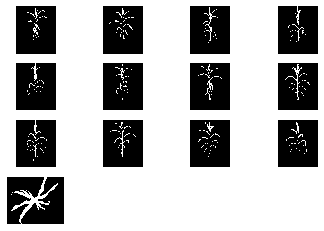

In [3]:
plant_number = 2 # Available : 1, 2, 3, 4 or 5
bin_images = phm_data.bin_images(plant_number=plant_number)
calibrations = phm_data.calibrations(plant_number=plant_number)

phm_display.show_images(list(bin_images['side'].values()) + 
                        list(bin_images['top'].values()))

## 2. Multi-view reconstruction

### 2.1 Associate images and projection function

In [4]:
def routine_select_ref_angle(bin_side_images):

    max_len = 0
    max_angle = None
    
    for angle in bin_side_images:
    
        x_pos, y_pos, x_len, y_len = cv2.boundingRect(cv2.findNonZero(bin_side_images[angle]))

        if x_len > max_len:
            max_len = x_len
            max_angle = angle

    return max_angle

In [5]:
refs_angle_list = [routine_select_ref_angle(bin_images["side"])]

image_views = list()
for id_camera in bin_images:
    for angle in bin_images[id_camera]:
        projection = calibrations[id_camera].get_projection(angle)
    
        image_ref = None
        if id_camera == "side" and angle in refs_angle_list:
            image_ref = bin_images[id_camera][angle]
        
        inclusive = False
        if id_camera == "top":
            inclusive = True
            
        image_views.append(phm_obj.ImageView(
            bin_images[id_camera][angle], 
            projection, 
            inclusive=inclusive, 
            image_ref=image_ref))

### 2.2 Do multi-view reconstruction

In [6]:
voxels_size = 16 # mm
error_tolerance = 0
voxel_grid = phm_mvr.reconstruction_3d(image_views, 
                                       voxels_size=voxels_size,
                                       error_tolerance=error_tolerance)

/home/artzet_s/code/phenomenal/src/openalea/phenomenal/multi_view_reconstruction/multi_view_reconstruction.py:544: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_integrale_image" failed type inference due to: Invalid use of Function(<function zeros_like at 0x7f2e4c0b3680>) with argument(s) of type(s): (array(uint8, 2d, C), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function zeros_like at 0x7f2e4c0b3680>)
[2] During: typing of call at /home/artzet_s/code/phenomenal/src/openalea/phenomenal/multi_view_reconstruction/multi_view_reconstruction.py (546)


File "../src/openalea/phenomenal/multi_view_reconstruction/multi_view_reconstruction.py", line 546:
def get_in

### 2.4 Save / Load voxel grid

In [7]:
voxel_grid.write("plant_{}_size_{}.npz".format(plant_number, voxels_size))

In [8]:
voxel_grid = phm_obj.VoxelGrid.read("plant_{}_size_{}.npz".format(plant_number, voxels_size))

### 2.5 Viewing

In [9]:
phm_display_notebook.show_voxel_grid(voxel_grid, size=1)

# 3.Meshing

In [10]:
vertices, faces = phm_mesh.meshing(voxel_grid.to_image_3d(),
                                   reduction=0.90,
                                   smoothing_iteration=5,
                                   verbose=True)

print("Number of vertices : {nb_vertices}".format(nb_vertices=len(vertices)))
print("Number of faces : {nb_faces}".format(nb_faces=len(faces)))

Marching cubes : 
	Iso value :0.5

	There are 10122 points.
	There are 20116 polygons.
Smoothing : 
	Feature angle :120.0
	Number of iteration :5
	Pass band : 0.01

Decimation : 
	Reduction (percentage) :0.9

	Before decimation
	-----------------
	There are 10122 points.
	There are 20116 polygons.

	After decimation
	-----------------
	There are 0.9 points.
	There are 10122 polygons.
Number of vertices : 1019
Number of faces : 2011


### 3.2 Viewing

In [11]:
phm_display_notebook.show_mesh(vertices, faces)